<a href="https://colab.research.google.com/github/GarettGazay/ai_projects/blob/master/RouteBuilder_TFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers 
!pip install sentencepiece
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 90.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 7.3 

In [2]:
# !nvcc --version

In [3]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

# %env CUDA_LAUNCH_BLOCKING=1
# %env TORCH_USE_CUDA_DSA=1

In [4]:
# import torch
# print(torch.__version__)

In [5]:
# %load_ext google.colab.data_table
# %debug


In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('ordering_dataset.csv')
df = df[df['trip_cost'] != 0] # we only want the model to deal with value, zeros will confuse it.
df = df.fillna(0)

In [8]:
df.head()

,pickup_timestamp,hour,minute,space_type,asset,trip_cost,status,rider_id,pickup_long,pickup_lat,dropoff_long,dropoff_lat,billable_distance
0,2021-10-30 04:30:00,4,30,WCH,SC105,69.875,<DR>,390520,-121.952339,37.385990,-121.902954,37.378399,7.106001
2,2021-10-30 05:00:00,5,0,WCH,SC301,100.850,<PF>,411690,-121.994217,37.342159,-121.979036,37.322465,2.596089
3,2021-10-30 05:15:00,5,15,BWC,SC107,154.400,<PF>,388852,-121.594933,37.023769,-121.812098,37.306048,26.139221
4,2021-10-30 05:27:10,5,27,STR,SC204,201.075,<PF>,390529,-121.894813,37.321892,-121.931571,37.311278,2.742732
5,2021-10-30 05:30:00,5,30,WCH,SC105,58.850,<PF>,390198,-121.949264,37.302544,-121.933708,37.315559,2.207732


In [9]:
import pandas as pd
import random
import numpy as np

def create_shuffled_target_lists(df):
    # Group rows by pickup date
    df['pickup_timestamp'] = pd.to_datetime(df['pickup_timestamp'])
    groups = df.groupby(df['pickup_timestamp'].dt.date)

    shuffled_rides = []
    target_order = []

    df['pickup_timestamp'] = pd.to_datetime(df['pickup_timestamp'])
    df['pickup_timestamp'] = df['pickup_timestamp'].dt.strftime('%Y-%m-%d %H:%M')  
    df['pickup_timestamp'] = df['pickup_timestamp'].astype(str)

    for name, group in groups:
        rides = group.iloc[1:, :].to_numpy()
        np.random.shuffle(rides)
        shuffled_rides.append(rides.tolist())
        target_order.append(group.iloc[1:, :].to_numpy().tolist()) # EXCLUDES HEADERS, AND FIRST FEATURE WHICH IS PICKUP TIMESTAMP - DONT WANT THAT.

    return shuffled_rides, target_order

x= create_shuffled_target_lists(df)
shuffled_rides = x[0]
target_order = x[1]

In [10]:
shuffled_rides[0][0]

['2021-10-30 17:30',
 17,
 30,
 'WCH',
 'SC107',
 25.175,
 '<PF>',
 390537,
 -121.8120978,
 37.3060479,
 -121.8320389,
 37.29574585,
 2.259927]

In [11]:
target_order[6][0]

['2021-11-23 04:30',
 4,
 30,
 'WCH',
 'SC101',
 69.65,
 '<PF>',
 388477,
 -122.0266571,
 37.32122421,
 -122.0791626,
 37.3829422,
 6.955629]

In [12]:
def create_dataset(shuffled_rides, target_order):
  dataset=[]
  count = 0

  for sr,to in zip(shuffled_rides, target_order):
    str_inputs = []
    str_targets = []

    for i in sr:
      # i_pickup_hour = str(i[0])
      # i_pickup_minute =str(i[1])
      i_pickup_date = str(i[0].split(' ')[0])
      i_pickup_time = str(i[0].split(' ')[1])
      i_space_type =str(i[3])
      i_trip_cost =str(round(i[5],2))
      i_status = str(i[6])
      i_rider_id =str(i[7])
      i_pickup_longitude =str(i[8])
      i_pickup_latitude =str(i[9])
      i_dropoff_longitude =str(i[10])
      i_dropoff_latitude =str(i[11])
      i_billable_distance = str(round(i[12],2))

      if i_status == '<PF>': # performed
        sequence = f'On {i_pickup_date} at {i_pickup_time}, {i_rider_id} with the condition of {i_space_type} will be picked up from ({i_pickup_longitude},{i_pickup_latitude}) and taken to their appointment located at ({i_dropoff_longitude},{i_dropoff_latitude}) the value of this ride is {i_trip_cost} and the distance from start to finish is {i_billable_distance} miles *'

      else: # dry run
        sequence = f'On {i_pickup_date} at {i_pickup_time}, {i_rider_id} with the condition of {i_space_type} was scheduled to be picked up for their appointment from ({i_pickup_longitude},{i_pickup_latitude}) and dropped off at ({i_dropoff_longitude},{i_dropoff_latitude}) the value of this ride was {i_trip_cost} and the distance from start to finish was {i_billable_distance} miles, but {i_rider_id} has canceled the ride *'

      str_inputs.append(sequence)
    
    for j in to:
      # j_pickup_hour = str(j[0])
      # j_pickup_minute = str(j[1])
      j_pickup_date = str(j[0].split(' ')[0])
      j_pickup_time = str(j[0].split(' ')[1])
      j_space_type = str(j[3])
      j_asset_id = str(j[4])
      j_trip_cost = str(round(j[5],2))
      j_rider_id = str(j[7])
      j_pickup_longitude = str(j[8])
      j_pickup_latitude = str(j[9])
      j_dropoff_longitude = str(j[10])
      j_dropoff_latitude = str(j[11])
      j_billable_distance = str(round(j[12],2))

      sequence = f'On {j_pickup_date} at {j_pickup_time}, driver {j_asset_id} will pick up {j_rider_id} with the condition of {j_space_type} from ({j_pickup_longitude},{j_pickup_latitude}) and dropped off at ({j_dropoff_longitude},{j_dropoff_latitude}) the value of this ride is {j_trip_cost} and the distance from start to finish is {j_billable_distance} miles *'
      str_targets.append(sequence)

    dataset.append({
        'id' : count,
        'input' : str_inputs,
        'target' : str_targets
    })
    count += 1

  return dataset

day = create_dataset(shuffled_rides, target_order)

In [13]:
len(day[344]['input'])

106

In [14]:
len(day[344]['target'])

106

In [15]:
for i in day[0]['input'][:10]:
  print(i + "\n")

On 2021-10-30 at 17:30, 390537 with the condition of WCH will be picked up from (-121.8120978,37.3060479) and taken to their appointment located at (-121.8320389,37.29574585) the value of this ride is 25.18 and the distance from start to finish is 2.26 miles *

On 2021-10-30 at 08:30, 388484 with the condition of STR will be picked up from (-121.9516678,37.38991928) and taken to their appointment located at (-122.0140457,37.37662125) the value of this ride is 207.38 and the distance from start to finish is 5.49 miles *

On 2021-10-30 at 05:00, 411690 with the condition of WCH will be picked up from (-121.9942169,37.34215927) and taken to their appointment located at (-121.9790364,37.322465) the value of this ride is 100.85 and the distance from start to finish is 2.6 miles *

On 2021-10-30 at 17:45, 388677 with the condition of BWC will be picked up from (-121.933667,37.315553) and taken to their appointment located at (-121.8692703,37.38211441) the value of this ride is 89.6 and the d

In [16]:
for i in day[50]['target'][:10]:
  print(i + "\n")

On 2022-01-12 at 04:46, driver SC103 will pick up 390524 with the condition of WCH from (-121.9228439,37.3158226) and dropped off at (-121.9373245,37.32392502) the value of this ride is 26.3 and the distance from start to finish is 2.81 miles *

On 2022-01-12 at 05:00, driver SC103 will pick up 414417 with the condition of WCH from (-121.9373245,37.32392502) and dropped off at (-121.9373245,37.32392502) the value of this ride is 95.0 and the distance from start to finish is 0.03 miles *

On 2022-01-12 at 05:00, driver SC101 will pick up 388477 with the condition of WCH from (-122.0266571,37.32122421) and dropped off at (-122.0791626,37.3829422) the value of this ride is 69.65 and the distance from start to finish is 6.96 miles *

On 2022-01-12 at 05:00, driver SC105 will pick up 388472 with the condition of WCH from (-122.0035248,37.4017868) and dropped off at (-121.9337082,37.31555939) the value of this ride is 83.6 and the distance from start to finish is 13.16 miles *

On 2022-01-12

In [17]:
len(day)

419

input lens:  [65, 66, 70, 62, 3, 105, 77, 95, 54, 76, 69, 97, 75, 101, 76, 108, 68, 105, 77, 111, 92, 108, 65, 100, 87, 108, 97, 100, 62, 109, 78, 105, 82, 86, 42, 102, 70, 96, 82, 95, 23, 36, 101, 73, 105, 74, 96, 52, 106, 78, 101, 76, 98, 58, 90, 73, 86, 88, 86, 54, 98, 80, 99, 84, 91, 60, 100, 88, 90, 74, 98, 67, 98, 87, 98, 88, 107, 65, 109, 83, 111, 88, 101, 72, 99, 80, 97, 90, 100, 57, 118, 97, 111, 87, 109, 72, 116, 90, 108, 89, 100, 69, 108, 93, 94, 100, 98, 69, 115, 85, 108, 87, 105, 73, 109, 86, 97, 81, 99, 70, 101, 93, 103, 87, 100, 64, 107, 89, 97, 93, 97, 66, 109, 90, 98, 88, 106, 64, 105, 93, 100, 92, 96, 68, 111, 84, 97, 95, 102, 65, 112, 102, 110, 79, 91, 72, 114, 91, 103, 93, 102, 65, 116, 94, 108, 80, 102, 64, 45, 49, 48, 47, 47, 53, 105, 90, 85, 78, 99, 64, 83, 75, 93, 84, 96, 67, 102, 84, 102, 88, 94, 74, 92, 88, 111, 95, 87, 68, 77, 82, 98, 91, 98, 69, 103, 91, 99, 99, 85, 69, 95, 88, 118, 78, 103, 65, 115, 82, 105, 90, 112, 70, 0, 105, 86, 101, 92, 97, 77, 104, 84

(array([ 3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  1.,  3.,  1.,  2.,  2.,  3.,  5.,  5.,
        12.,  6., 15.,  6., 14., 14., 11., 22., 14., 24., 15., 22., 32.,
        21., 43., 27., 17., 18., 15., 21.,  4., 11.,  4.,  2.]),
 array([  0.  ,   2.42,   4.84,   7.26,   9.68,  12.1 ,  14.52,  16.94,
         19.36,  21.78,  24.2 ,  26.62,  29.04,  31.46,  33.88,  36.3 ,
         38.72,  41.14,  43.56,  45.98,  48.4 ,  50.82,  53.24,  55.66,
         58.08,  60.5 ,  62.92,  65.34,  67.76,  70.18,  72.6 ,  75.02,
         77.44,  79.86,  82.28,  84.7 ,  87.12,  89.54,  91.96,  94.38,
         96.8 ,  99.22, 101.64, 104.06, 106.48, 108.9 , 111.32, 113.74,
        116.16, 118.58, 121.  ]),
 <BarContainer object of 50 artists>)

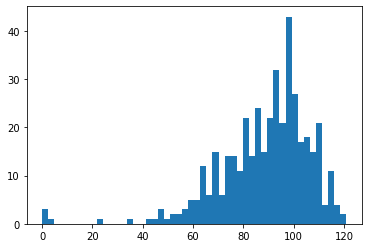

In [18]:
# This plot shows where the cluster of number of rides per day is, from here we can drop outlies like those below 65
import matplotlib.pyplot as plt
input_lens = [len(x) for x in target_order]
print('input lens: ', input_lens)
plt.hist(input_lens, bins=50)

CGPT: Yes, your strategy seems reasonable. Splitting your transportation rides into chunks of N with an average of N tokens per chunk is a good approach for fine-tuning BART-base. Adding a special token to identify the chunks as belonging together in chronological order is also a good idea as it will help the model learn the temporal relationship between the chunks.

You should also make sure that you properly tokenize the chunks using the BART tokenizer and make sure that the maximum sequence length is set to N, which is the maximum input length that BART-base can handle. Additionally, you may want to consider using a data collator that will handle padding and truncation of your sequences during training.

Overall, your approach seems viable and should work well for fine-tuning BART-base on your transportation ride data.

In [19]:
import math

# Chunk input and target sequences
largest_sequence = 7038 #  len of the largest token sequence in the dataset
num_chunks = 7 # how many chunks we want to break the sequence up into
global_chunk_size = math.ceil((largest_sequence / num_chunks)) # the chunk size we will provide to downstream logic

print('Chunk Size: ',global_chunk_size)

Chunk Size:  1006


In [20]:
day[0]['target']

['On 2021-10-30 at 05:00, driver SC301 will pick up 411690 with the condition of WCH from (-121.9942169,37.34215927) and dropped off at (-121.9790364,37.322465) the value of this ride is 100.85 and the distance from start to finish is 2.6 miles *',
 'On 2021-10-30 at 05:15, driver SC107 will pick up 388852 with the condition of BWC from (-121.5949326,37.02376938) and dropped off at (-121.8120978,37.3060479) the value of this ride is 154.4 and the distance from start to finish is 26.14 miles *',
 'On 2021-10-30 at 05:27, driver SC204 will pick up 390529 with the condition of STR from (-121.8948135,37.32189178) and dropped off at (-121.9315708,37.3112781) the value of this ride is 201.07 and the distance from start to finish is 2.74 miles *',
 'On 2021-10-30 at 05:30, driver SC105 will pick up 390198 with the condition of WCH from (-121.9492645,37.30254364) and dropped off at (-121.9337082,37.31555939) the value of this ride is 58.85 and the distance from start to finish is 2.21 miles *'

In [21]:
count = 0
count_id = 0 # incrementes the id of each dict so they are in a sequential order from start to end and each dict has a unique id
new_rides_dataset=[] # fill with generated chunks for each day of rides sequences
chunk_tokens=[]
for i in range(len(day)):
  input = day[i]['input'] # input at each iteration
  target = day[i]['target'] # target at each iteration

  input_chunks_holder=[] # holds the input chunks for each iteration
  target_chunks_holder=[] # holds the target chunks for each iteration

  target_len = len(target)
  if target_len > 50: # skip any days that don't offer sufficient training data so it doesn't waste resources and slow down training.
    
    chunk_size = len(target) // num_chunks # break the day up into chunks based on the target length

    input_chunk1 = input[:chunk_size]
    input_chunk2 = input[chunk_size:2*chunk_size]
    input_chunk3 = input[2*chunk_size:3*chunk_size]
    input_chunk4 = input[3*chunk_size:4*chunk_size]
    input_chunk5 = input[4*chunk_size:5*chunk_size]
    input_chunk6 = input[5*chunk_size:6*chunk_size]
    input_chunk7 = input[6*chunk_size:]

    target_chunk1 = target[:chunk_size]
    target_chunk2 = target[chunk_size:2*chunk_size]
    target_chunk3 = target[2*chunk_size:3*chunk_size]
    target_chunk4 = target[3*chunk_size:4*chunk_size]
    target_chunk5 = target[4*chunk_size:5*chunk_size]
    target_chunk6 = target[5*chunk_size:6*chunk_size]
    target_chunk7 = target[6*chunk_size:]

    # Add chunk token Id's
    chunk1_token = f'<START_{count}>' # also used for the df
    chunk2_token = f'<CONT_{count}_1>'
    chunk3_token = f'<CONT_{count}_2>'
    chunk4_token = f'<CONT_{count}_3>'
    chunk5_token = f'<CONT_{count}_4>'
    chunk6_token = f'<CONT_{count}_5>'
    chunk7_token = f'<END_{count}>'

    chunk_tokens.append([chunk1_token, chunk2_token, chunk3_token, chunk4_token, chunk5_token, chunk6_token, chunk7_token]) # add for the vocab file

    target_chunk1.append(chunk1_token)
    target_chunk2.append(chunk2_token)
    target_chunk3.append(chunk3_token)
    target_chunk4.append(chunk4_token)
    target_chunk5.append(chunk5_token)
    target_chunk6.append(chunk6_token)
    target_chunk7.append(chunk7_token)

    # Shuffle the input chunk 
    np.random.shuffle(input_chunk1)
    np.random.shuffle(input_chunk2)
    np.random.shuffle(input_chunk3)
    np.random.shuffle(input_chunk4)
    np.random.shuffle(input_chunk5)
    np.random.shuffle(input_chunk6)
    np.random.shuffle(input_chunk7)

    # Append chunk token for inputs after they've been shuffled
    input_chunk1.append(chunk1_token)
    input_chunk2.append(chunk2_token)
    input_chunk3.append(chunk3_token)
    input_chunk4.append(chunk4_token)
    input_chunk5.append(chunk5_token)
    input_chunk6.append(chunk6_token)
    input_chunk7.append(chunk7_token)


    # Add chunks with tags to the new rides_dataset as seperate sequences 
    # which will be understood as a single sequence by their chunk tags
    new_rides_dataset.append({
        'id' : count_id,
        'input' : input_chunk1, # Start
        'target' : target_chunk1 # Start
        })
    count_id += 1
    
    new_rides_dataset.append({
        'id' : count_id,
        'input' : input_chunk2,  # Cont 1
        'target' : target_chunk2 # Cont 1
        })
    count_id += 1
    new_rides_dataset.append({
        'id' : count_id,
        'input' : input_chunk3,  # Cont 2
        'target' : target_chunk3 # Cont 2
        })
    count_id += 1
    new_rides_dataset.append({
        'id' : count_id,
        'input' : input_chunk4,  # Cont 3
        'target' : target_chunk4 # Cont 3
        })
    count_id += 1
    new_rides_dataset.append({
        'id' : count_id,
        'input' : input_chunk5,  # Cont 4
        'target' : target_chunk5 # Cont 4
        })
    count_id += 1
    new_rides_dataset.append({
      'id' : count_id,
      'input' : input_chunk6,  # Cont 6
      'target' : target_chunk6 # Cont 6
      })
    
    count_id += 1
    new_rides_dataset.append({
        'id' : count_id,
        'input' : input_chunk7, # End
        'target' : target_chunk7 # End
        })
    count_id += 1

    count +=1

rides_dataset = new_rides_dataset
print('Total Input and Target sequences [[start],[mid],[end]]:',count)

Total Input and Target sequences [[start],[mid],[end]]: 407


In [22]:
# count = 0
# count_id = 0 # incrementes the id of each dict so they are in a sequential order from start to end and each dict has a unique id
# new_rides_dataset=[] # fill with generated chunks for each day of rides sequences
# chunk_tokens=[]
# for i in range(len(rides_dataset)):
#   input = rides_dataset[i]['input']
#   target = rides_dataset[i]['target']


#   target_len = len(target)
#   if target_len > 50: # skip any days that don't offer sufficient training data so it doesn't waste resources and slow down training.
    
#     chunk_size = len(target) // num_chunks # break the day up into chunks based on the target length
#     input_chunk1 = input[:chunk_size]
#     input_chunk2 = input[chunk_size:2*chunk_size]
#     input_chunk3 = input[2*chunk_size:]

#     target_chunk1 = target[:chunk_size]
#     target_chunk2 = target[chunk_size:2*chunk_size]
#     target_chunk3 = target[2*chunk_size:]

#     # Add chunk token Id's
#     chunk1_token = f'<START_{count}>' # also used for the df
#     chunk2_token = f'<MID_{count}>'
#     chunk3_token = f'<END_{count}>'

#     chunk_tokens.append([chunk1_token, chunk2_token, chunk3_token]) # add for the vocab file

#     target_chunk1.append(chunk1_token)
#     target_chunk2.append(chunk2_token)
#     target_chunk3.append(chunk3_token)

#     # Shuffle the input chunk 
#     np.random.shuffle(input_chunk1)
#     np.random.shuffle(input_chunk2)
#     np.random.shuffle(input_chunk3)

#     # Append chunk token for inputs after they've been shuffled
#     input_chunk1.append(chunk1_token)
#     input_chunk2.append(chunk2_token)
#     input_chunk3.append(chunk3_token)


#     # Add chunks with tags to the new rides_dataset as seperate sequences 
#     # which will be understood as a single sequence by their chunk tags
#     new_rides_dataset.append({
#         'id' : count_id,
#         'input' : input_chunk1, # Start
#         'target' : target_chunk1 # Start
#         })
#     count_id += 1
    
#     new_rides_dataset.append({
#         'id' : count_id,
#         'input' : input_chunk2,  # Mid
#         'target' : target_chunk2 # Mid
#         })
#     count_id += 1
#     new_rides_dataset.append({
#         'id' : count_id,
#         'input' : input_chunk3, # End
#         'target' : target_chunk3 # End
#         })
#     count_id += 1

#     count +=1
#     # if count == 5:
#     #   print(new_rides_dataset[0]['input'])
#     #   print(new_rides_dataset[0]['target'])
#     #   break
# rides_dataset = new_rides_dataset
# print('Total Input and Target sequences [[start],[mid],[end]]:',count)

In [23]:
rides_dataset[6]

{'id': 6,
 'input': ['On 2021-10-30 at 09:45, 388691 with the condition of WCH will be picked up from (-121.9314804,37.31127167) and taken to their appointment located at (-121.9243088,37.39934158) the value of this ride is 42.5 and the distance from start to finish is 10.03 miles *',
  'On 2021-10-30 at 09:45, 390540 with the condition of WCH will be picked up from (-121.8941803,37.29782867) and taken to their appointment located at (-121.931483,37.31127) the value of this ride is 77.88 and the distance from start to finish is 3.53 miles *',
  'On 2021-10-30 at 08:30, 388505 with the condition of BWC will be picked up from (-121.8325653,37.33570862) and taken to their appointment located at (-121.8270276,37.2519668) the value of this ride is 93.6 and the distance from start to finish is 10.86 miles *',
  'On 2021-10-30 at 09:15, 390527 with the condition of STR will be picked up from (-122.0218887,37.36326981) and taken to their appointment located at (-122.0140457,37.37662125) the va

In [24]:
# Add chunk tokens to a df which can be used to add them to the vocabulary
chunk_tokens_df = pd.DataFrame(chunk_tokens)
chunk_tokens_df.tail()

,0,1,2,3,4,5,6
402,<START_402>,<CONT_402_1>,<CONT_402_2>,<CONT_402_3>,<CONT_402_4>,<CONT_402_5>,<END_402>
403,<START_403>,<CONT_403_1>,<CONT_403_2>,<CONT_403_3>,<CONT_403_4>,<CONT_403_5>,<END_403>
404,<START_404>,<CONT_404_1>,<CONT_404_2>,<CONT_404_3>,<CONT_404_4>,<CONT_404_5>,<END_404>
405,<START_405>,<CONT_405_1>,<CONT_405_2>,<CONT_405_3>,<CONT_405_4>,<CONT_405_5>,<END_405>
406,<START_406>,<CONT_406_1>,<CONT_406_2>,<CONT_406_3>,<CONT_406_4>,<CONT_406_5>,<END_406>


Create dataset with train test split

In [25]:
rides_dataset[0]

{'id': 0,
 'input': ['On 2021-10-30 at 05:00, 411690 with the condition of WCH will be picked up from (-121.9942169,37.34215927) and taken to their appointment located at (-121.9790364,37.322465) the value of this ride is 100.85 and the distance from start to finish is 2.6 miles *',
  'On 2021-10-30 at 17:30, 390537 with the condition of WCH will be picked up from (-121.8120978,37.3060479) and taken to their appointment located at (-121.8320389,37.29574585) the value of this ride is 25.18 and the distance from start to finish is 2.26 miles *',
  'On 2021-10-30 at 05:30, 390198 with the condition of WCH will be picked up from (-121.9492645,37.30254364) and taken to their appointment located at (-121.9337082,37.31555939) the value of this ride is 58.85 and the distance from start to finish is 2.21 miles *',
  'On 2021-10-30 at 08:30, 388484 with the condition of STR will be picked up from (-121.9516678,37.38991928) and taken to their appointment located at (-122.0140457,37.37662125) the 

In [13]:
x ='OnOnat 13:15, driver SC105 will pick up 388526 with the condition of WCH from ( -121.8113861, 37.30517197 ) and dropped off at ( -121.9314804, 37.31127167 ) the value of this ride isand the distance from start to finish is 2.78 miles * On On Onat 13:15 at 13:15 09:30, driver SC302 will pick 388739 with the value59 miles *, 37.31860733 )7 miles * ride is 5.51 miles *) the distance 08:30, driver SC104 will pick pick up 390529 with the distance 37.3015213 ) and the value 8.33 miles * 1.33 and dropped driver SC104 3 miles *from ( -121.8272247, 37.31860733.33181818306, 37.30213547 ) the 05:00, 37.3112793 ) theiles * On is 2 8.3 2 and the 8.3 2 miles * * Onat 09:00, driver SC106 will pick 388934 with the, driver SC202 will pick 388496 with the WCH from (-, 37.30517197 37.32392883 ) and) and, 37.30517197 37.30517197 ) the condition) the96 and the distance) the 8.3 8 and the 4.78 and the condition.51 and dropped 3.33at 10:00, driver SC103 will pick 388488 with the ( -121.9314804 37.35033798 ) and -121.8272247, 37.30517197 37.30604935 ) and up 390529 ) the of this value of STR from start.38 and the 12.337 and the driver SC104 8 miles * value of BWC from ( -121.93367, driver SC402 will pick 390540 with the STR from ( -121.8113861'

x = x.split('*')
x[1]

' On On Onat 13:15 at 13:15 09:30, driver SC302 will pick 388739 with the value59 miles '

In [10]:
|from datasets import DatasetDict, load_dataset
import pandas as pd

# Convert list of dictionaries to new format
data_format = [{'id': d['id'], 'translation': {'input': d['input'], 'target': d['target']}} for d in rides_dataset]

# Convert new format list of dictionaries to pandas DataFrame
full_dataset = pd.DataFrame.from_records(data_format, columns=['id', 'translation'])

# Write DataFrame to CSV file
full_dataset.to_csv("full_dataset.csv", index=False)

# Load the training and test datasets
full_dataset = load_dataset('csv', data_files="full_dataset.csv")
train_dataset = full_dataset['train'].train_test_split(test_size=0.2, shuffle=False) # We want the tts in the chronological order specified above
dataset_dict = DatasetDict({'train': train_dataset['train'], 'test': train_dataset['test']})


NameError: ignored

input lens:  [65, 66, 70, 62, 3, 105, 77, 95, 54, 76, 69, 97, 75, 101, 76, 108, 68, 105, 77, 111, 92, 108, 65, 100, 87, 108, 97, 100, 62, 109, 78, 105, 82, 86, 42, 102, 70, 96, 82, 95, 23, 36, 101, 73, 105, 74, 96, 52, 106, 78, 101, 76, 98, 58, 90, 73, 86, 88, 86, 54, 98, 80, 99, 84, 91, 60, 100, 88, 90, 74, 98, 67, 98, 87, 98, 88, 107, 65, 109, 83, 111, 88, 101, 72, 99, 80, 97, 90, 100, 57, 118, 97, 111, 87, 109, 72, 116, 90, 108, 89, 100, 69, 108, 93, 94, 100, 98, 69, 115, 85, 108, 87, 105, 73, 109, 86, 97, 81, 99, 70, 101, 93, 103, 87, 100, 64, 107, 89, 97, 93, 97, 66, 109, 90, 98, 88, 106, 64, 105, 93, 100, 92, 96, 68, 111, 84, 97, 95, 102, 65, 112, 102, 110, 79, 91, 72, 114, 91, 103, 93, 102, 65, 116, 94, 108, 80, 102, 64, 45, 49, 48, 47, 47, 53, 105, 90, 85, 78, 99, 64, 83, 75, 93, 84, 96, 67, 102, 84, 102, 88, 94, 74, 92, 88, 111, 95, 87, 68, 77, 82, 98, 91, 98, 69, 103, 91, 99, 99, 85, 69, 95, 88, 118, 78, 103, 65, 115, 82, 105, 90, 112, 70, 0, 105, 86, 101, 92, 97, 77, 104, 84

(array([ 3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  1.,  3.,  1.,  2.,  2.,  3.,  5.,  5.,
        12.,  6., 15.,  6., 14., 14., 11., 22., 14., 24., 15., 22., 32.,
        21., 43., 27., 17., 18., 15., 21.,  4., 11.,  4.,  2.]),
 array([  0.  ,   2.42,   4.84,   7.26,   9.68,  12.1 ,  14.52,  16.94,
         19.36,  21.78,  24.2 ,  26.62,  29.04,  31.46,  33.88,  36.3 ,
         38.72,  41.14,  43.56,  45.98,  48.4 ,  50.82,  53.24,  55.66,
         58.08,  60.5 ,  62.92,  65.34,  67.76,  70.18,  72.6 ,  75.02,
         77.44,  79.86,  82.28,  84.7 ,  87.12,  89.54,  91.96,  94.38,
         96.8 ,  99.22, 101.64, 104.06, 106.48, 108.9 , 111.32, 113.74,
        116.16, 118.58, 121.  ]),
 <BarContainer object of 50 artists>)

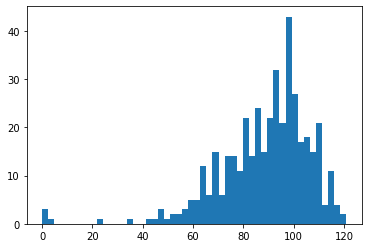

In [27]:
import matplotlib.pyplot as plt
input_lens = [len(x) for x in target_order]
print('input lens: ', input_lens)
plt.hist(input_lens, bins=50)

If you want the model to predict the vehicle ID during the ordering prediction, you can remove the vehicle ID from the input sequence that you provide to the model and train the model to predict it as part of the output sequence.

For example, during training, you can provide the model with a sequence of rides without the vehicle ID, and train it to output the correct order of rides along with the corresponding vehicle ID for each ride.

During inference, you can provide the model with a sequence of rides without the vehicle ID, and let it predict the correct order of rides along with the corresponding vehicle ID for each ride.

In [28]:
# Get all the text columns and concatenate them with numerical columns
text_columns = df.select_dtypes(include=['object', 'float', 'int']).astype(str).apply(lambda x: ' '.join(x.dropna()), axis=1)

# Concatenate all the text columns into one long string
text = ' '.join(text_columns)

# Split the string into a list of unique words
unique_words = list(set(text.split()))

# Write the unique words to a text file, one word per line
with open('custom_vocab.txt', 'w') as f:
    f.write('\n'.join(unique_words))



In [29]:
# Append chunk tokens to the custom vocab file
text_columns = chunk_tokens_df.select_dtypes(include=['object']).astype(str).apply(lambda x: ' '.join(x.dropna()), axis=1)
text = ' '.join(text_columns)
unique_words = list(set(text.split()))

with open('custom_vocab.txt', 'a') as f:
    f.write('\n'.join(unique_words))


In [30]:
# Open the text file
with open('custom_vocab.txt', 'r') as f:
    # Read the contents of the file into a list
    custom_vocab = [line.split('\n')[0] for line in f.readlines()]

# Print the list
print(custom_vocab)
print(len(custom_vocab))

['188.44', '5.506592', '50.6475', '495267', '338323', '37.38976288', '6.738149', '187.96', '12.596437', '17:40', '35.9075', '445496', '49.725', '388492', '110.93', '6', '37.38518', '-121.800626', '57', '37.4150797', '219.4575', '307.55', '-122.120429', '140.4975', '-121.8526853', '5.235674', '0.416319', '2.204625', '2.848366', '48.7775', '4.767781', '12.456007', '67.95', '2022-01-20', '14.988716', '37.342158', '37.328022', '37.41426086', '246.075', '30.485', '37.309678', '99.4975', '131.475', '14.430103', '249.2', 'BWC', '78.7175', '-122.16876', '137.145', '2021-11-13', '496558', '2022-05-31', '-121.5663071', '207.6', '37.477653', '294.36', '133.96', '58.41', '103.8875', '372.08', '171.6875', '109.1', '100.895', '22.852167', '-121.934751', '2.440746', '2021-12-17', '-121.961174', '1.118468', '37.30719376', '37.272817', '126.255', '228.75', '218.6475', '-121.8016739', '422023', '-121.966938', '37.250832', '183.25', '320.9', '81.6775', '86.75', '9.203129', '37.31605516', '443.92', '4.531

In [31]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, BartForConditionalGeneration, BartTokenizer, BartConfig
input_max_length=global_chunk_size
target_max_length=global_chunk_size

checkpoint='facebook/bart-base'
tokenizer = BartTokenizer.from_pretrained(checkpoint)

# Add the new words to the tokenizer's vocabulary
tokenizer.add_tokens(custom_vocab)

config = BartConfig.from_pretrained(checkpoint)
config.vocab_size = config.vocab_size + len(custom_vocab)

model = BartForConditionalGeneration(config=config)
print('Default BART model vocab size: 50265')
print('New model vocab size: ', config.vocab_size)
print('Tokenizer vocab size: ', tokenizer.vocab_size)

Default BART model vocab size: 50265
New model vocab size:  60860
Tokenizer vocab size:  50265


In [32]:
for token in custom_vocab:
    if token in tokenizer.get_vocab():
        print(f"Token '{token}' already in vocabulary")
        break
    else:
        print(f"Token '{token}' not in vocabulary")

Token '188.44' already in vocabulary


In [33]:
tokenizer.vocab_size
# this is also the same for BARTConfig

50265

 the return_tensors='pt' argument is needed if you want the tokenizer function to return PyTorch tensors instead of tokenized text. This is useful if you plan to directly pass the output of the tokenizer to a BART model, as BART expects PyTorch tensors as input. If you don't use return_tensors='pt', the tokenizer function will return a dictionary of lists, where each list contains the tokenized text.

In [34]:
def tokenizer_fn(batch):
    # Get the inputs and targets from the batch
    examples = batch['translation']
    example_ids = batch['id']

    # Create a list of dictionaries that contain both the input, target, and example id
    example_dicts = [{'input': eval(x)['input'], 'target': eval(x)['target'], 'id': ex_id} for x, ex_id in zip(examples, example_ids)]
    
    # Sort the examples based on the 'id' key in each dictionary
    examples = sorted(example_dicts, key=lambda x: x['id'])
    
    # Extract the inputs and targets from the sorted examples
    inputs = [' '.join(ex['input']) for ex in examples]
    targets = [' '.join(ex['target']) for ex in examples]

    # Tokenize the inputs and targets
    tokenized_inputs = tokenizer(inputs, max_length=global_chunk_size, truncation=True)
    tokenized_targets = tokenizer(targets, max_length=global_chunk_size, truncation=True)
    
    # Add the labels to the tokenized_inputs
    tokenized_inputs['labels'] = tokenized_targets['input_ids']
    print(f'Batch chunk sizes: ', global_chunk_size)
    return tokenized_inputs


In [35]:
dataset_train_df = pd.DataFrame(dataset_dict['train'])
dataset_test_df = pd.DataFrame(dataset_dict['test'])
dataset_train_df.to_csv('dataset_train_df.csv')
dataset_test_df.to_csv('dataset_test_df.csv')

In [36]:
# Apply the tokenizer function to the dataset using the 'map()' method
tokenized_datasets = dataset_dict.map(
    tokenizer_fn,
    batched=True,
    remove_columns=dataset_dict['train'].column_names
)

Map:   0%|          | 0/2279 [00:00<?, ? examples/s]

Batch chunk sizes:  1006
Batch chunk sizes:  1006
Batch chunk sizes:  1006


Map:   0%|          | 0/570 [00:00<?, ? examples/s]

Batch chunk sizes:  1006


In [37]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2279
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 570
    })
})

In [38]:
def get_max_token_len(category):
  # category is either 'input' or 'target'
  data_string = [x for x in day]
  data_string = [data_string[x][category] for x in range(0,len(data_string))]
  data_string = [''.join(x) for x in data_string]
  _tokenized_dataset = [tokenizer(x) for x in data_string] # gets the tokenized rides for that day's category
  input_ids = [encoding["input_ids"] for encoding in _tokenized_dataset] # gets the input ids so they can be maxxed
  lens = [len(x) for x in input_ids]
  print(lens)
  plt.hist(lens, bins=50)
  return max(lens), min(lens)

Token indices sequence length is longer than the specified maximum sequence length for this model (3524 > 1024). Running this sequence through the model will result in indexing errors


[3524, 3575, 3765, 3334, 167, 5666, 4173, 5132, 2948, 4096, 3743, 5239, 4030, 5416, 4093, 5843, 3669, 5656, 4154, 6007, 4987, 5818, 3507, 5388, 4691, 5853, 5256, 5421, 3355, 5873, 4201, 5657, 4457, 4629, 2262, 5530, 3796, 5148, 4429, 5111, 1263, 1953, 5421, 3933, 5662, 3991, 5168, 2806, 5683, 4207, 5427, 4079, 5254, 3122, 4838, 3934, 4647, 4765, 4628, 2932, 5262, 4296, 5332, 4516, 4910, 3217, 5362, 4722, 4831, 3981, 5267, 3598, 5260, 4657, 5286, 4757, 5736, 3497, 5878, 4464, 5967, 4722, 5417, 3895, 5314, 4289, 5248, 4852, 5369, 3097, 6353, 5217, 5976, 4709, 5866, 3871, 6247, 4834, 5804, 4793, 5361, 3709, 5810, 5018, 5050, 5377, 5247, 3703, 6189, 4572, 5803, 4696, 5634, 3923, 5854, 4642, 5209, 4354, 5333, 3767, 5404, 5004, 5525, 4691, 5373, 3456, 5771, 4806, 5234, 4992, 5190, 3550, 5847, 4862, 5263, 4774, 5702, 3458, 5647, 5009, 5407, 4993, 5180, 3670, 5981, 4549, 5224, 5158, 5473, 3498, 6058, 5494, 5905, 4247, 4879, 3865, 6141, 4910, 5534, 4990, 5471, 3508, 6229, 5054, 5792, 4302, 5478

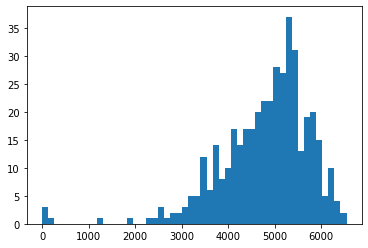

In [39]:
input_token_len = get_max_token_len('input')

# The error "Token indices sequence length is longer than the specified maximum sequence length for this model (1619 > 32). 
# Running this sequence through the model will result in indexing errors
# occurs because the day sequence is longer than the model can handle, but we're just trying to get
# the max tokens from day so we can use it for chunking above when we need to change chunking

[3358, 3416, 3625, 3210, 161, 5438, 3983, 4924, 2804, 3935, 3569, 5000, 3880, 5214, 3923, 5582, 3524, 5419, 3982, 5731, 4749, 5584, 3359, 5170, 4481, 5583, 5008, 5167, 3204, 5628, 4027, 5429, 4239, 4439, 2178, 5263, 3611, 4947, 4238, 4912, 1181, 1872, 5210, 3769, 5425, 3816, 4958, 2684, 5462, 4015, 5216, 3918, 5058, 2997, 4640, 3770, 4430, 4544, 4438, 2797, 5048, 4127, 5107, 4330, 4692, 3097, 5153, 4537, 4642, 3824, 5062, 3455, 5055, 4483, 5063, 4554, 5522, 3358, 5633, 4280, 5736, 4537, 5206, 3724, 5107, 4120, 5009, 4645, 5160, 2956, 6090, 5005, 5718, 4508, 5630, 3718, 5988, 4645, 5588, 4615, 5161, 3562, 5567, 4814, 4844, 5168, 5051, 3565, 5923, 4402, 5578, 4504, 5415, 3777, 5618, 4461, 4997, 4192, 5108, 3618, 5193, 4800, 5310, 4499, 5155, 3310, 5503, 4610, 5004, 4806, 4996, 3418, 5620, 4655, 5058, 4553, 5472, 3312, 5410, 4814, 5162, 4755, 4943, 3516, 5714, 4345, 5003, 4914, 5260, 3359, 5771, 5272, 5676, 4080, 4688, 3721, 5877, 4701, 5310, 4804, 5267, 3360, 5988, 4848, 5576, 4133, 5256

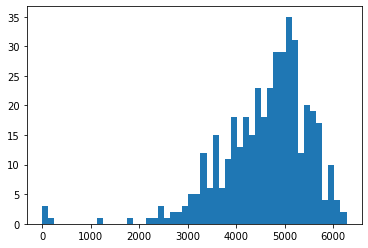

In [40]:
target_token_len = get_max_token_len('target')

In [41]:
# Get the highest number of day tokens for chunking  2543 / 3 = 849
input_token_len, target_token_len

((6542, 2), (6273, 2))

In [42]:
# input id tokens [505, 9175, 2128, 9175, 35524, 1820, 36604, 1820, 36722, 1820, 39638, 1820, 32518, 1820, ...]
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'<s>On 2021-10-30 at 05:00, 411690 with the condition of WCH will be picked up from ( -121.9942169, 37.34215927 ) and taken to their appointment located at ( -121.9790364, 37.322465 ) the value of this ride is 100.85 and the distance from start to finish is 2.6 miles * On 2021-10-30 at 17:30, 390537 with the condition of WCH will be picked up from ( -121.8120978, 37.3060479 ) and taken to their appointment located at ( -121.8320389, 37.29574585 ) the value of this ride is 25.18 and the distance from start to finish is 2.26 miles * On 2021-10-30 at 05:30, 390198 with the condition of WCH will be picked up from ( -121.9492645, 37.30254364 ) and taken to their appointment located at ( -121.9337082, 37.31555939 ) the value of this ride is 58.85 and the distance from start to finish is 2.21 miles * On 2021-10-30 at 08:30, 388484 with the condition of STR will be picked up from ( -121.9516678, 37.38991928 ) and taken to their appointment located at ( -122.0140457, 37.37662125 ) the value of 

In [43]:
# label tokens [305, 9175, 1808, 9175, 35524, 1820, 39055, 1820, 39119, 1820, 35073, 1820, 5033, 9175, 5647, ...]
# tokenized_datasets['train'][0]['labels']
tokenizer.decode(tokenized_datasets['train'][0]['labels'])

'<s>On 2021-10-30 at 05:00, driver SC301 will pick up 411690 with the condition of WCH from ( -121.9942169, 37.34215927 ) and dropped off at ( -121.9790364, 37.322465 ) the value of this ride is 100.85 and the distance from start to finish is 2.6 miles * On 2021-10-30 at 05:15, driver SC107 will pick up 388852 with the condition of BWC from ( -121.5949326, 37.02376938 ) and dropped off at ( -121.8120978, 37.3060479 ) the value of this ride is 154.4 and the distance from start to finish is 26.14 miles * On 2021-10-30 at 05:27, driver SC204 will pick up 390529 with the condition of STR from ( -121.8948135, 37.32189178 ) and dropped off at ( -121.9315708, 37.3112781 ) the value of this ride is 201.0 7 and the distance from start to finish is 2.74 miles * On 2021-10-30 at 05:30, driver SC105 will pick up 390198 with the condition of WCH from ( -121.9492645, 37.30254364 ) and dropped off at ( -121.9337082, 37.31555939 ) the value of this ride is 58.85 and the distance from start to finish i

In [44]:
# In general, it's not uncommon for input_ids and labels to have different lengths
len(tokenized_datasets['train'][0]['input_ids']), len(tokenized_datasets['train'][0]['labels'])

(485, 465)

In [45]:
input_ids_len = []
for i in range(len(tokenized_datasets['train'])):
  input_ids_len.append(len(tokenized_datasets['train'][i]['input_ids']))

labels_len = []
for i in range(len(tokenized_datasets['train'])):
  labels_len.append(len(tokenized_datasets['train'][i]['labels']))

print(f'Max Num Input Ids: {max(input_ids_len)} \n Max Num labels: {max(labels_len)}')
print(f'Min Num Input Ids: {min(input_ids_len)} \n Min Num labels: {min(labels_len)}')

Max Num Input Ids: 1006 
 Max Num labels: 1006
Min Num Input Ids: 375 
 Min Num labels: 359


In [46]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [47]:
# check the labels and decoder input ids to make sure shifting has taken place
batch = data_collator([tokenized_datasets['train'][i] for i in range(1,3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

The batch dictionary is training examples, and the labels key in the batch dictionary contains the labels for the corresponding input sequences. In the context of sequence-to-sequence modeling, the labels typically represent the "target" or "output" sequence that the model is being trained to generate given the corresponding input sequence.

In [48]:
batch['labels'][0][:10]

tensor([    0,  4148, 53346,   415, 57222,     6,  1393, 55264,  6677,  1339])

Think of seq2seq RNNs, the decoder RNN must have some input. This allows the decoder to predict the next word, given the previous words from the encoder. THE DECODER IDS ARE A SHIFTED FORWARD ONE - VERSION OF THE TARGETS SO THE DECODER CAN TRAIN TO PREDICT THE NEXT TOKEN IN A SEQUENCE.

In [49]:
batch['decoder_input_ids'][0][:10]

tensor([    2,     0,  4148, 53346,   415, 57222,     6,  1393, 55264,  6677])

In [50]:
# the decoder input ids are shifted forward by adding the </s> at the front of the list
tokenizer.convert_ids_to_tokens(batch['decoder_input_ids'][0]) 

['</s>',
 '<s>',
 'On',
 '2021-10-30',
 'at',
 '08:15',
 ',',
 'Ġdriver',
 'SC105',
 'will',
 'Ġpick',
 'Ġup',
 '388526',
 'with',
 'Ġthe',
 'Ġcondition',
 'Ġof',
 'WCH',
 'from',
 'Ġ(',
 '-121.9255905',
 ',',
 '37.31228256',
 ')',
 'Ġand',
 'Ġdropped',
 'Ġoff',
 'Ġat',
 'Ġ(',
 '-121.9315708',
 ',',
 '37.3112781',
 ')',
 'Ġthe',
 'Ġvalue',
 'Ġof',
 'Ġthis',
 'Ġride',
 'Ġis',
 'Ġ4',
 '8.3',
 '8',
 'Ġand',
 'Ġthe',
 'Ġdistance',
 'Ġfrom',
 'Ġstart',
 'Ġto',
 'Ġfinish',
 'Ġis',
 'Ġ1',
 '.',
 '5',
 'Ġmiles',
 'Ġ*',
 'ĠOn',
 '2021-10-30',
 'at',
 '08:15',
 ',',
 'Ġdriver',
 'SC105',
 'will',
 'Ġpick',
 'Ġup',
 '388851',
 'with',
 'Ġthe',
 'Ġcondition',
 'Ġof',
 'BWC',
 'from',
 'Ġ(',
 '-121.8116608',
 ',',
 '37.26219559',
 ')',
 'Ġand',
 'Ġdropped',
 'Ġoff',
 'Ġat',
 'Ġ(',
 '-121.826913',
 ',',
 '37.251936',
 ')',
 'Ġthe',
 'Ġvalue',
 'Ġof',
 'Ġthis',
 'Ġride',
 'Ġis',
 '50.0',
 'and',
 'Ġthe',
 'Ġdistance',
 'Ġfrom',
 'Ġstart',
 'Ġto',
 'Ġfinish',
 'Ġis',
 'Ġ2',
 '.',
 '52',
 'Ġmiles',
 'Ġ

In [51]:
len(batch['decoder_input_ids'][0]), len(batch['labels'][0])


(472, 472)

In [52]:
# labels are in line with the target data, the decoder input ids are shifted forward
# now the model can compare the target to the predicted next token
tokenizer.convert_ids_to_tokens(batch['labels'][0])

['<s>',
 'On',
 '2021-10-30',
 'at',
 '08:15',
 ',',
 'Ġdriver',
 'SC105',
 'will',
 'Ġpick',
 'Ġup',
 '388526',
 'with',
 'Ġthe',
 'Ġcondition',
 'Ġof',
 'WCH',
 'from',
 'Ġ(',
 '-121.9255905',
 ',',
 '37.31228256',
 ')',
 'Ġand',
 'Ġdropped',
 'Ġoff',
 'Ġat',
 'Ġ(',
 '-121.9315708',
 ',',
 '37.3112781',
 ')',
 'Ġthe',
 'Ġvalue',
 'Ġof',
 'Ġthis',
 'Ġride',
 'Ġis',
 'Ġ4',
 '8.3',
 '8',
 'Ġand',
 'Ġthe',
 'Ġdistance',
 'Ġfrom',
 'Ġstart',
 'Ġto',
 'Ġfinish',
 'Ġis',
 'Ġ1',
 '.',
 '5',
 'Ġmiles',
 'Ġ*',
 'ĠOn',
 '2021-10-30',
 'at',
 '08:15',
 ',',
 'Ġdriver',
 'SC105',
 'will',
 'Ġpick',
 'Ġup',
 '388851',
 'with',
 'Ġthe',
 'Ġcondition',
 'Ġof',
 'BWC',
 'from',
 'Ġ(',
 '-121.8116608',
 ',',
 '37.26219559',
 ')',
 'Ġand',
 'Ġdropped',
 'Ġoff',
 'Ġat',
 'Ġ(',
 '-121.826913',
 ',',
 '37.251936',
 ')',
 'Ġthe',
 'Ġvalue',
 'Ġof',
 'Ġthis',
 'Ġride',
 'Ġis',
 '50.0',
 'and',
 'Ġthe',
 'Ġdistance',
 'Ġfrom',
 'Ġstart',
 'Ġto',
 'Ġfinish',
 'Ġis',
 'Ġ2',
 '.',
 '52',
 'Ġmiles',
 'Ġ*',
 'ĠOn

Here, we are first getting the indices of the highest values in the logits tensor (which will give us the predicted labels), and then we are also getting the indices of the highest values in the labels tensor. We are then using these indices to calculate the accuracy and f1 score using the accuracy_score and f1_score functions from scikit-learn. Note that we are using the 'weighted' averaging method for the f1 score since we have a multiclass-multioutput problem.

In [53]:
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    labels = np.argmax(labels, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'f1': f1}

In [54]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    'finetuned-model',
    evaluation_strategy='no',
    save_strategy='epoch',
    warmup_steps=500, # *
    learning_rate=2e-5,
    per_device_train_batch_size=8, #32
    per_device_eval_batch_size=16, #64
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    logging_dir='./logs', # *
    logging_steps=100,# *
    predict_with_generate=True,
    # load_best_model_at_end=True, # *
    fp16=True,
)

In [55]:
from transformers import Seq2SeqTrainer

# small_train = tokenized_datasets['train'].select(range(10))
# small_test = tokenized_datasets['test'].select(range(5))

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

{'eval_loss': 11.240900039672852,
 'eval_accuracy': 0.0,
 'eval_f1': 0.0,
 'eval_runtime': 3965.0096,
 'eval_samples_per_second': 0.144,
 'eval_steps_per_second': 0.009}

In [56]:
# check metrics before starting training
# trainer.evaluate(max_length=target_max_length)

In [57]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,10.087100
200,7.408600
300,4.046900
400,2.310700
500,1.573100
600,1.373100
700,1.288400
800,1.254800


TrainOutput(global_step=855, training_loss=3.511924886424639, metrics={'train_runtime': 217.1572, 'train_samples_per_second': 31.484, 'train_steps_per_second': 3.937, 'total_flos': 3544017541908480.0, 'train_loss': 3.511924886424639, 'epoch': 3.0})

In [59]:
trainer.save_model('oracle_model')

Model evaluation

In [2]:
from transformers import BartForConditionalGeneration, BartTokenizer

model_path = '/content/drive/MyDrive/Colab_Models/OracleTRF/oracle_model'
model = BartForConditionalGeneration.from_pretrained(model_path)
tokenizer = BartTokenizer.from_pretrained(model_path)

In [3]:
test=['On 2021-10-30 at 05:00, 411690 with the condition of WCH will be picked up from (-121.9942169,37.34215927) and taken to their appointment located at (-121.9790364,37.322465) the value of this ride is 100.85 and the distance from start to finish is 2.6 miles *',
  'On 2021-10-30 at 17:30, 390537 with the condition of WCH will be picked up from (-121.8120978,37.3060479) and taken to their appointment located at (-121.8320389,37.29574585) the value of this ride is 25.18 and the distance from start to finish is 2.26 miles *',
  'On 2021-10-30 at 05:30, 390198 with the condition of WCH will be picked up from (-121.9492645,37.30254364) and taken to their appointment located at (-121.9337082,37.31555939) the value of this ride is 58.85 and the distance from start to finish is 2.21 miles *',
  'On 2021-10-30 at 08:30, 388484 with the condition of STR will be picked up from (-121.9516678,37.38991928) and taken to their appointment located at (-122.0140457,37.37662125) the value of this ride is 207.38 and the distance from start to finish is 5.49 miles *',
  'On 2021-10-30 at 17:00, 388690 with the condition of WCH will be picked up from (-121.8348389,37.31568909) and taken to their appointment located at (-121.8412247,37.32992172) the value of this ride is 26.75 and the distance from start to finish is 2.98 miles *',
  'On 2021-10-30 at 16:45, 388479 with the condition of WCH will be picked up from (-122.0140457,37.37662125) and taken to their appointment located at (-122.0238342,37.3819046) the value of this ride is 22.48 and the distance from start to finish is 1.05 miles *',
  'On 2021-10-30 at 13:00, 388488 with the condition of WCH will be picked up from (-122.0695877,37.41511917) and taken to their appointment located at (-122.079144,37.382993) the value of this ride is 40.75 and the distance from start to finish is 4.17 miles *',
  'On 2021-10-30 at 13:12, 388702 with the condition of WCH will be picked up from (-121.8411942,37.36575317) and taken to their appointment located at (-121.933667,37.315553) the value of this ride is 88.67 and the distance from start to finish is 8.32 miles *',
  'On 2021-10-30 at 17:45, 388677 with the condition of BWC will be picked up from (-121.933667,37.315553) and taken to their appointment located at (-121.8692703,37.38211441) the value of this ride is 89.6 and the distance from start to finish is 9.89 miles *',
  '<START_0>'
  ]

test = ''.join(test)
test

'On 2021-10-30 at 05:00, 411690 with the condition of WCH will be picked up from (-121.9942169,37.34215927) and taken to their appointment located at (-121.9790364,37.322465) the value of this ride is 100.85 and the distance from start to finish is 2.6 miles *On 2021-10-30 at 17:30, 390537 with the condition of WCH will be picked up from (-121.8120978,37.3060479) and taken to their appointment located at (-121.8320389,37.29574585) the value of this ride is 25.18 and the distance from start to finish is 2.26 miles *On 2021-10-30 at 05:30, 390198 with the condition of WCH will be picked up from (-121.9492645,37.30254364) and taken to their appointment located at (-121.9337082,37.31555939) the value of this ride is 58.85 and the distance from start to finish is 2.21 miles *On 2021-10-30 at 08:30, 388484 with the condition of STR will be picked up from (-121.9516678,37.38991928) and taken to their appointment located at (-122.0140457,37.37662125) the value of this ride is 207.38 and the di

In [4]:
input_text = test
input_ids = tokenizer.encode(input_text, return_tensors='pt')
input_ids

tensor([[    0,  4148, 53346,   415, 52350,     6, 50470,  5632,     5,  1881,
             9, 57905,  6677,    28,  2738,    62,    31,    36, 55204,     6,
         56808,    43,     8,   551,     7,    49,  4916,  2034,    23,    36,
         51482,     6, 56486,    43,     5,   923,     9,    42,  3068,    16,
         51016,   463,     5,  4472,    31,   386,     7,  2073,    16,   132,
             4,   401,  1788,  1009,  4148, 53346,   415, 52889,     6, 51419,
          5632,     5,  1881,     9, 57905,  6677,    28,  2738,    62,    31,
            36, 56677,     6, 50561,    43,     8,   551,     7,    49,  4916,
          2034,    23,    36, 56020,     6, 53827,    43,     5,   923,     9,
            42,  3068,    16,   564,     4,  1366,     8,     5,  4472,    31,
           386,     7,  2073,    16,   132,     4,  2481,  1788,  1009,  4148,
         53346,   415, 53288,     6, 57278,  5632,     5,  1881,     9, 57905,
          6677,    28,  2738,    62,    31,    36, 5

In [16]:
output_ids = model.generate(input_ids, max_length=1011) # should be global_chunk_size when not testing

In [17]:
output_ids

tensor([[    2,     0,  4148,  4148,   415, 53999,     6,  1393, 55264,  6677,
          1339,    62, 51781,  5632,     5,  1881,     9, 57905,  7761,    36,
         53837,     6, 51190,    43,     8,  1882,   160,    23,    36, 55419,
             6, 56800,    43,     5,   923,     9,    42,  3068,    16,   463,
             5,  4472,    31,   386,     7,  2073,    16,   132,     4,  5479,
          1788,  1009,   374,   374,   374,   415, 53999,   415, 53999, 57129,
             6,  1393, 54657,  6677,  1339, 53403,  5632,     5,   923,  4156,
          1788,  1009,     6, 53100,    43,   406,  1788,  1009,  3068,    16,
           195,     4,  4708,  1788,  1009,    43,     5,  4472, 53914,     6,
          1393, 55102,  6677,  1339,  1339,    62, 51899,  5632,     5,  4472,
         56326,    43,     8,     5,   923,   290,     4,  3103,  1788,  1009,
           112,     4,  3103,     8,  1882,  1393, 55102,   246,  1788,  1009,
          7761,    36, 52631,     6, 53100,     4,  

In [18]:
# Decode the output text.
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(output_text)

OnOnat 13:15, driver SC105 will pick up 388526 with the condition of WCH from ( -121.8113861, 37.30517197 ) and dropped off at ( -121.9314804, 37.31127167 ) the value of this ride isand the distance from start to finish is 2.78 miles * On On Onat 13:15 at 13:15 09:30, driver SC302 will pick 388739 with the value59 miles *, 37.31860733 )7 miles * ride is 5.51 miles *) the distance 08:30, driver SC104 will pick pick up 390529 with the distance 37.3015213 ) and the value 8.33 miles * 1.33 and dropped driver SC104 3 miles *from ( -121.8272247, 37.31860733.33181818306, 37.30213547 ) the 05:00, 37.3112793 ) theiles * On is 2 8.3 2 and the 8.3 2 miles * * Onat 09:00, driver SC106 will pick 388934 with the, driver SC202 will pick 388496 with the WCH from (-, 37.30517197 37.32392883 ) and) and, 37.30517197 37.30517197 ) the condition) the96 and the distance) the 8.3 8 and the 4.78 and the condition.51 and dropped 3.33at 10:00, driver SC103 will pick 388488 with the ( -121.9314804 37.35033798 ) 